# Lab 3: Unsupervised Learning — KMeans, DBSCAN, PCA, and KMeans Variants

## Objective
In this lab, you will explore **unsupervised learning algorithms** using the **Wine dataset**.  
You’ll apply:
- **KMeans** and determine the optimal number of clusters.  
- **DBSCAN** for density-based clustering and anomaly detection.  
- **PCA** for dimensionality reduction and performance comparison.  
- **A research-based KMeans variant** (e.g., MiniBatchKMeans, Bisecting KMeans, Kernel KMeans).  

You will **quantitatively evaluate** each approach using metrics such as:
- Silhouette Score  
- Calinski–Harabasz Index  
- Davies–Bouldin Index  
- Runtime Efficiency  

---

# 1 - Setup and Data Loading (5pts)

In this section, you will:
1. Load the Wine dataset from `sklearn.datasets`.
2. Inspect the dataset’s structure (features, types, missing values).
3. Standardize the feature values to prepare for clustering.

## Creating the dataframe

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine, make_classification
from sklearn.preprocessing import StandardScaler

In [ ]:
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## Checking for null values

In [ ]:
df.isnull().sum()

,0
alcohol,0
malic_acid,0
ash,0
alcalinity_of_ash,0
magnesium,0
total_phenols,0
flavanoids,0
nonflavanoid_phenols,0
proanthocyanins,0
color_intensity,0


## Checking for categorical columns

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category', 'string', 'bool']).columns.tolist()
categorical_columns

[]

## Converting all columns to numeric types

In [ ]:
df = df.apply(pd.to_numeric, errors="coerce")
df.dtypes

,0
alcohol,float64
malic_acid,float64
ash,float64
alcalinity_of_ash,float64
magnesium,float64
total_phenols,float64
flavanoids,float64
nonflavanoid_phenols,float64
proanthocyanins,float64
color_intensity,float64


## Standardizing features

In [ ]:
X = df.drop(columns=['target'])
y = df['target']
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

# 2 - Implement KMeans for k = 2 to 10 and compute inertia and silhouette scores

## K-Means Clustering Evaluation

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
k_wcss = [] # within-cluster sum of squares
k_ss = [] # silhouette scores
k_chs = [] # calinski-harabasz score
k_dbs = [] # davies-bouldin score

K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_

    k_wcss.append(kmeans.inertia_)
    k_ss.append(silhouette_score(X_scaled, labels))
    k_chs.append(calinski_harabasz_score(X_scaled, labels))
    k_dbs.append(davies_bouldin_score(X_scaled, labels))

delta = [0]  # no Δ for K=1
for k in range(1, len(k_wcss)):
    delta_k = (k_wcss[k-1] - k_wcss[k]) / k_wcss[k-1]
    delta.append(delta_k)

## Visualizing the Elbow Method with Relative Improvement

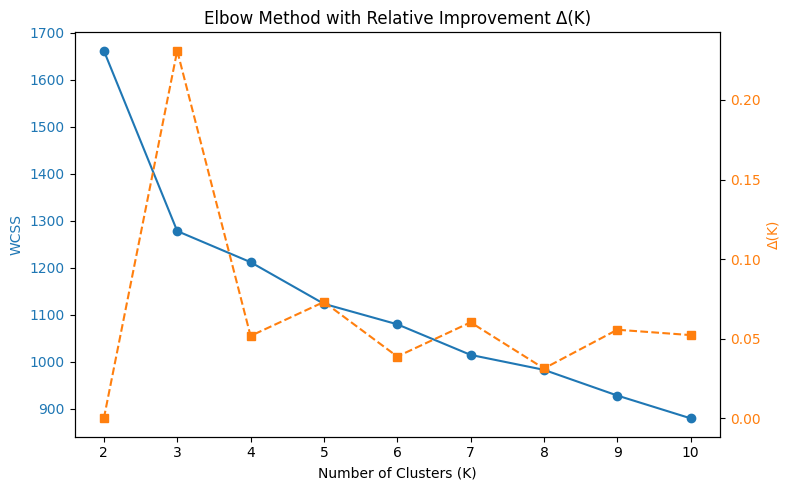

,K,WCSS,Delta(K)
0,2,1661.676117,0.000000
1,3,1277.928489,0.230940
2,4,1211.753113,0.051783
3,5,1123.156547,0.073114
4,6,1079.538509,0.038835
5,7,1014.430909,0.060311
6,8,982.654976,0.031324
7,9,927.956076,0.055664
8,10,879.425701,0.052298


In [ ]:
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(K_range, k_wcss, 'o-', color=color, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Δ(K)', color=color)
ax2.plot(K_range, delta, 's--', color=color, label='Δ(K)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method with Relative Improvement Δ(K)')
fig.tight_layout()
plt.show()

results = pd.DataFrame({
    'K': list(K_range),
    'WCSS': k_wcss,
    'Delta(K)': delta
})

results

## Finding the optimal number of clusters

In [ ]:
optimal_k = K_range[np.argmax(k_ss)]
print(f"Optimal number of clusters (K) based on maximum Δ(K): {optimal_k}")

Optimal number of clusters (K) based on maximum Δ(K): 3


## Plotting Silhouette Score

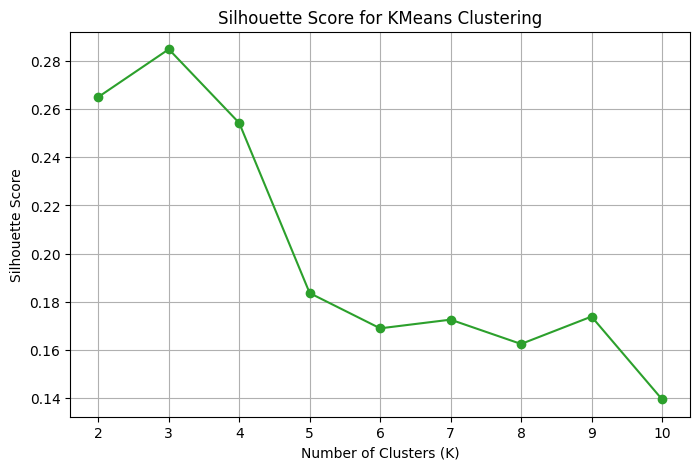

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(K_range, k_ss, 'o-', color='tab:green', label='Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans Clustering')
plt.grid(True)
plt.show()

results['Silhouette Score'] = k_ss

## Plotting Calinski-Harabasz Score

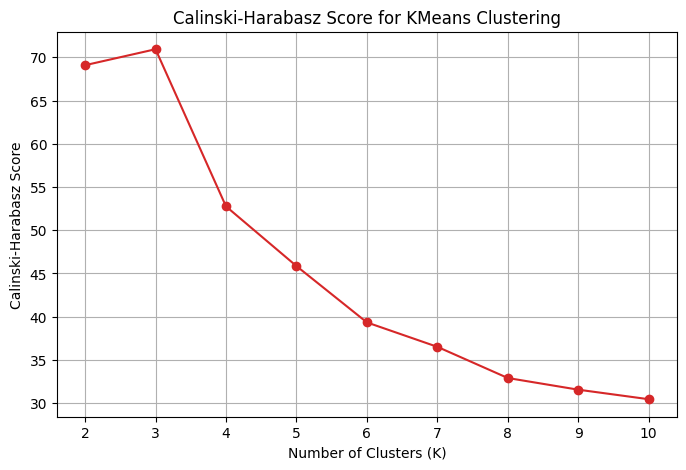

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(K_range, k_chs, 'o-', color='tab:red', label='Calinski-Harabasz Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score for KMeans Clustering')
plt.grid(True)
plt.show()

results['Calinski-Harabasz Score'] = k_chs

## Plotting Davies-Bouldin Score


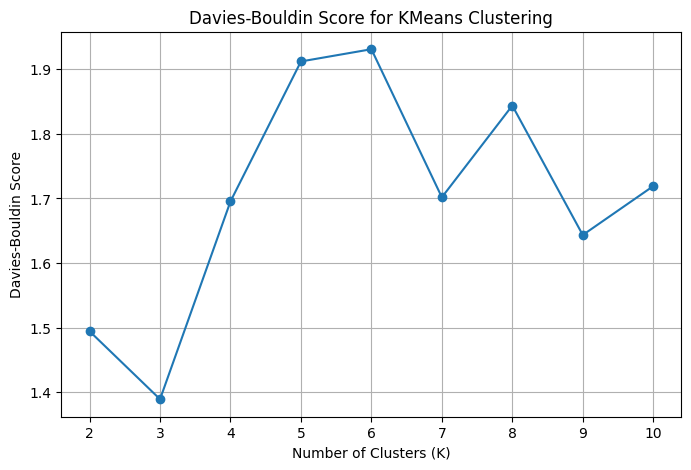

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(K_range, k_dbs, 'o-', color='tab:blue', label='Davies-Bouldin Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score for KMeans Clustering')
plt.grid(True)
plt.show()

results['Davies Bouldin Score'] = k_dbs

# 3 - Implement DBSCAN with different parameter values


## Getting the maximum possible value of eps

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
eps_max = X_scaled.max()
eps_max

np.float64(4.371372139554768)

## Implementing DBSCAN across eps and min_samples

In [ ]:
i = 0.2
DB_range = range(2, 11)
best_score = -1
best_params = None
db_ss = []
db_chs = []
db_dbs = []

while i < eps_max:
  for j in DB_range:
    db = DBSCAN(eps=i, min_samples=j).fit(X_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    db_score = silhouette_score(X_scaled, labels) if n_clusters > 1 else -1
    db_ss.append(db_score)
    db_chs.append(calinski_harabasz_score(X_scaled, labels) if n_clusters > 1 else -1)
    db_dbs.append(davies_bouldin_score(X_scaled, labels) if n_clusters > 1 else -1)

    print(f"eps={i}: min_samples={j}, clusters={len(set(labels))-('noise' in labels)}, silhouette={db_score:.3f}")

    if db_score > best_score:
      best_score = db_score
      best_params = (i, j, n_clusters)

  i = round(i + 0.2, 2)

eps_best, min_samples_best, n_clusters_best = best_params
print(f"Maximum silhouette score: {best_score:.3f} achieved with eps={eps_best:.2f}, "
      f"min_samples={min_samples_best}, clusters={n_clusters_best}")

eps=0.2: min_samples=2, clusters=1, silhouette=-1.000
eps=0.2: min_samples=3, clusters=1, silhouette=-1.000
eps=0.2: min_samples=4, clusters=1, silhouette=-1.000
eps=0.2: min_samples=5, clusters=1, silhouette=-1.000
eps=0.2: min_samples=6, clusters=1, silhouette=-1.000
eps=0.2: min_samples=7, clusters=1, silhouette=-1.000
eps=0.2: min_samples=8, clusters=1, silhouette=-1.000
eps=0.2: min_samples=9, clusters=1, silhouette=-1.000
eps=0.2: min_samples=10, clusters=1, silhouette=-1.000
eps=0.4: min_samples=2, clusters=1, silhouette=-1.000
eps=0.4: min_samples=3, clusters=1, silhouette=-1.000
eps=0.4: min_samples=4, clusters=1, silhouette=-1.000
eps=0.4: min_samples=5, clusters=1, silhouette=-1.000
eps=0.4: min_samples=6, clusters=1, silhouette=-1.000
eps=0.4: min_samples=7, clusters=1, silhouette=-1.000
eps=0.4: min_samples=8, clusters=1, silhouette=-1.000
eps=0.4: min_samples=9, clusters=1, silhouette=-1.000
eps=0.4: min_samples=10, clusters=1, silhouette=-1.000
eps=0.6: min_samples=2, cl

## Visualizing the parameters with the maximum silhouette score

In [ ]:
db = DBSCAN(eps=eps_best, min_samples=min_samples_best).fit(X_scaled)
labels = db.labels_

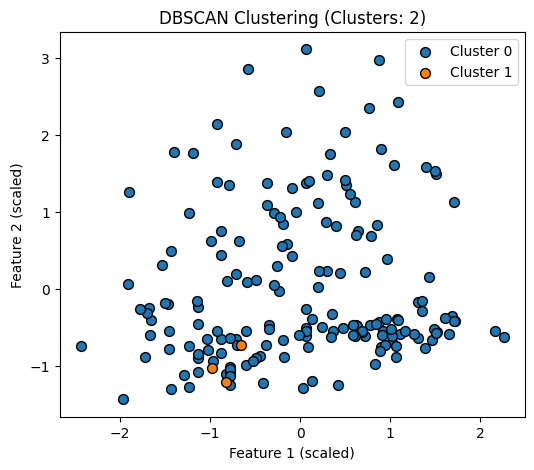

In [ ]:
plt.figure(figsize=(6,5))

unique_labels = set(labels)
colors = [plt.cm.tab10(i) for i in range(len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 0.6]
        label = 'Noise'
    else:
        label = f'Cluster {k}'

    class_member_mask = (labels == k)
    xy = X_scaled[class_member_mask]

    plt.scatter(xy[:, 0], xy[:, 1], s=50, color=col, label=label, edgecolors='k')

plt.title(f"DBSCAN Clustering (Clusters: {n_clusters_best})")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend()
plt.show()

## Comparing the performance of KMeans and DBSCAN

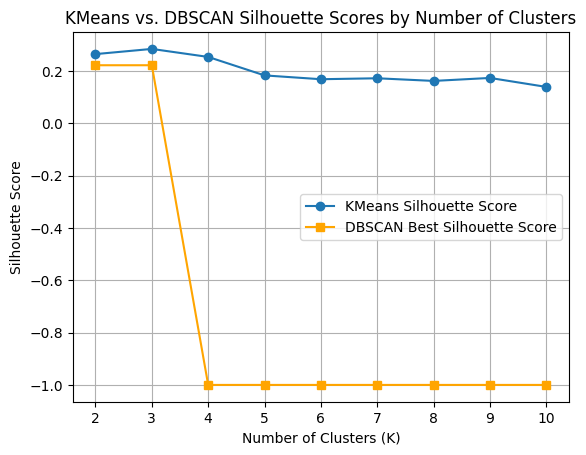

[np.float64(0.2650328591008738),
 np.float64(0.2848589191898987),
 np.float64(0.25422758316007776),
 np.float64(0.18362105107698137),
 np.float64(0.16899191019013057),
 np.float64(0.1726015561094921),
 np.float64(0.16250411307671142),
 np.float64(0.1738739334545086),
 np.float64(0.13956723664297546)]

In [ ]:
kmeans_scores = []
dbscan_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    kmeans_labels = kmeans.labels_
    kmeans_score = silhouette_score(X_scaled, kmeans_labels)
    kmeans_scores.append(kmeans_score)

    dbscan = DBSCAN(eps=eps_best, min_samples=k).fit(X_scaled)
    dbscan_labels = dbscan.labels_
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    db_score = silhouette_score(X_scaled, dbscan_labels) if n_clusters > 1 else -1
    dbscan_scores.append(db_score)

plt.plot(K_range, kmeans_scores, label="KMeans Silhouette Score", marker='o', color='tab:blue')
plt.plot(K_range, dbscan_scores, label="DBSCAN Best Silhouette Score", marker='s', color='orange')

plt.title("KMeans vs. DBSCAN Silhouette Scores by Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

k_ss

# 4 - Apply PCA and visualize explained variance ratio

## Applying PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [ ]:
components_df = pd.DataFrame(
    pca.components_,
    columns=[f'Feature{i+1}' for i in range(X.shape[1])]
)
components_df.index = [f'PC{i+1}' for i in range(X.shape[1])]
print("\nPrincipal Component Loadings:")
print(components_df.round(3))


Principal Component Loadings:
      Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
PC1      0.144    -0.245    -0.002    -0.239     0.142     0.395     0.423   
PC2      0.484     0.225     0.316    -0.011     0.300     0.065    -0.003   
PC3     -0.207     0.089     0.626     0.612     0.131     0.146     0.151   
PC4     -0.018     0.537    -0.214     0.061    -0.352     0.198     0.152   
PC5     -0.266     0.035    -0.143     0.066     0.727    -0.149    -0.109   
PC6      0.214     0.537     0.154    -0.101     0.038    -0.084    -0.019   
PC7     -0.056     0.421    -0.149    -0.287     0.323    -0.028    -0.061   
PC8      0.396     0.066    -0.170     0.428    -0.156    -0.406    -0.187   
PC9     -0.509     0.075     0.308    -0.200    -0.271    -0.286    -0.050   
PC10     0.212    -0.309    -0.027     0.053     0.068    -0.320    -0.163   
PC11    -0.226     0.076    -0.499     0.479     0.071     0.304    -0.026   
PC12    -0.266     0.122    -0.05

In [ ]:
pca_results = []

for n in range(1, X.shape[1] + 1):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, random_state=42
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    pca_results.append((n, acc, pca.explained_variance_ratio_.sum()))

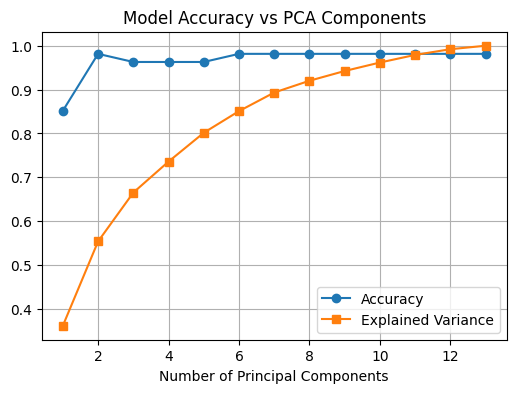


Accuracy and variance by component count:
    n_components  accuracy  explained_var
0              1     0.852          0.362
1              2     0.981          0.554
2              3     0.963          0.665
3              4     0.963          0.736
4              5     0.963          0.802
5              6     0.981          0.851
6              7     0.981          0.893
7              8     0.981          0.920
8              9     0.981          0.942
9             10     0.981          0.962
10            11     0.981          0.979
11            12     0.981          0.992
12            13     0.981          1.000


In [ ]:
acc_df = pd.DataFrame(pca_results, columns=['n_components', 'accuracy', 'explained_var'])

plt.figure(figsize=(6,4))
plt.plot(acc_df['n_components'], acc_df['accuracy'], marker='o', label='Accuracy')
plt.plot(acc_df['n_components'], acc_df['explained_var'], marker='s', label='Explained Variance')
plt.xlabel('Number of Principal Components')
plt.legend()
plt.grid(True)
plt.title('Model Accuracy vs PCA Components')
plt.show()

print("\nAccuracy and variance by component count:")
print(acc_df.round(3))

## Plotting the cumulative explained variance

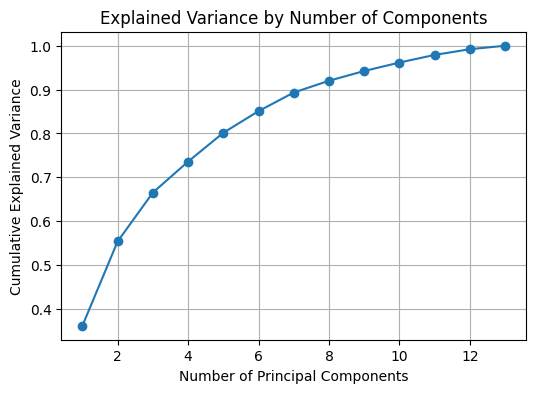

Number of components for >=90% variance: 8
Actual variance retained: 92.02%
Original dimensions: (178, 13)
Reduced dimensions: (178, 8)


In [ ]:
explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

n_components_90 = np.argmax(explained_var >= 0.90) + 1
print(f"Number of components for >=90% variance: {n_components_90}")
print(f"Actual variance retained: {explained_var[n_components_90-1]*100:.2f}%")

pca_optimal = PCA(n_components=n_components_90, random_state=42)
X_pca_reduced = pca_optimal.fit_transform(X_scaled)

print(f"Original dimensions: {X_scaled.shape}")
print(f"Reduced dimensions: {X_pca_reduced.shape}")

## Comparing performance before and after PCA

In [ ]:
kmeans_pca_scores = []

for k in K_range:
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(X_pca_reduced)
    labels_pca = kmeans_pca.labels_
    kmeans_pca_scores.append(silhouette_score(X_pca_reduced, labels_pca))

optimal_k_pca = K_range[np.argmax(kmeans_pca_scores)]
print(f"Optimal K on PCA-reduced data: {optimal_k_pca}")

kmeans_original = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_original.fit(X_scaled)
labels_original = kmeans_original.labels_

kmeans_reduced = KMeans(n_clusters=optimal_k_pca, random_state=42)
kmeans_reduced.fit(X_pca_reduced)
labels_reduced = kmeans_reduced.labels_

performance_comparison = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'],
    'Before PCA': [
        silhouette_score(X_scaled, labels_original),
        calinski_harabasz_score(X_scaled, labels_original),
        davies_bouldin_score(X_scaled, labels_original)
    ],
    'After PCA': [
        silhouette_score(X_pca_reduced, labels_reduced),
        calinski_harabasz_score(X_pca_reduced, labels_reduced),
        davies_bouldin_score(X_pca_reduced, labels_reduced)
    ]
})

performance_comparison.round(3)

Optimal K on PCA-reduced data: 3


,Metric,Before PCA,After PCA
0,Silhouette Score,0.285,0.315
1,Calinski-Harabasz Score,70.940,82.746
2,Davies-Bouldin Score,1.389,1.267


/tmp/ipython-input-3934505124.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K_range, k_ss, 'o-', marker='o', label='Original Data')
/tmp/ipython-input-3934505124.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s--" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(K_range, kmeans_pca_scores, 's--', marker='s', label='PCA (8 Components)', alpha=0.7)


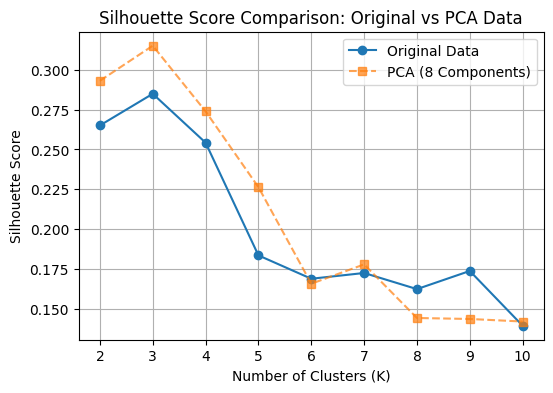

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(K_range, k_ss, 'o-', marker='o', label='Original Data')
plt.plot(K_range, kmeans_pca_scores, 's--', marker='s', label='PCA (8 Components)', alpha=0.7)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison: Original vs PCA Data')
plt.legend()
plt.grid(True)
plt.show()

# 5 - Clustering Variations

a. Research on a variation of KMeans
b. Implement the variation and repeat process in item #2


In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
mb_wcss = []
mb_silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    mb_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=50).fit(X_scaled)
    labels_mb = mb_kmeans.labels_
    mb_wcss.append(mb_kmeans.inertia_)
    mb_silhouette_scores.append(silhouette_score(X_scaled, labels_mb))

mb_delta = [0]
for k in range(1, len(mb_wcss)):
    delta_k = (mb_wcss[k-1] - mb_wcss[k]) / mb_wcss[k-1]
    mb_delta.append(delta_k)

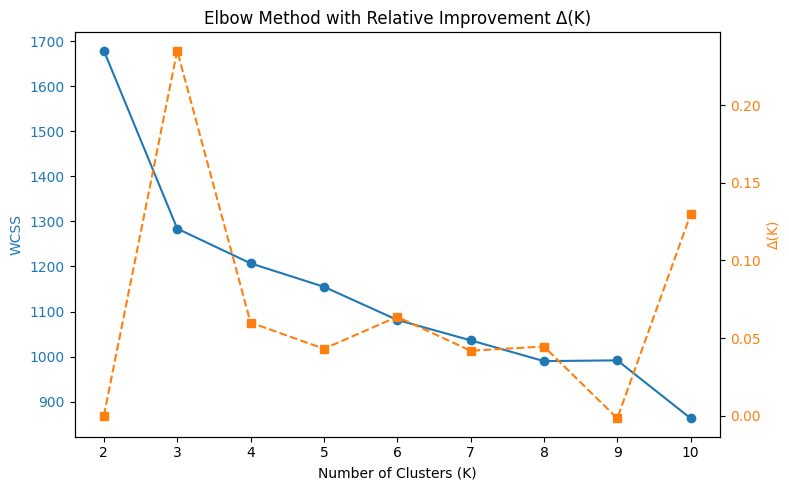

,K,WCSS,Delta(K)
0,2,1678.702803,0.000000
1,3,1283.978278,0.235137
2,4,1206.954254,0.059989
3,5,1154.936896,0.043098
4,6,1081.372622,0.063695
5,7,1036.129709,0.041838
6,8,989.976415,0.044544
7,9,991.687593,-0.001729
8,10,863.009367,0.129757


In [ ]:
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(K_range, mb_wcss, 'o-', color=color, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Δ(K)', color=color)
ax2.plot(K_range, mb_delta, 's--', color=color, label='Δ(K)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method with Relative Improvement Δ(K)')
fig.tight_layout()
plt.show()

results = pd.DataFrame({
    'K': list(K_range),
    'WCSS': mb_wcss,
    'Delta(K)': mb_delta
})

results

/tmp/ipython-input-2344121602.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K_range, k_ss, 'o-', marker='o', label='Standard KMeans')
/tmp/ipython-input-2344121602.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s--" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(K_range, mb_silhouette_scores, 's--', marker='s', label='MiniBatchKMeans', alpha=0.7)


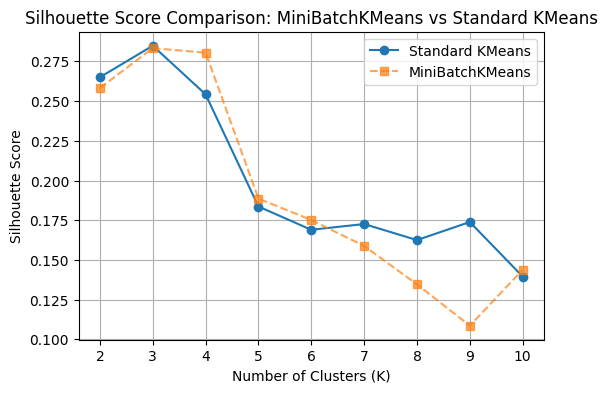

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(K_range, k_ss, 'o-', marker='o', label='Standard KMeans')
plt.plot(K_range, mb_silhouette_scores, 's--', marker='s', label='MiniBatchKMeans', alpha=0.7)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison: MiniBatchKMeans vs Standard KMeans')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimal_k_mb = K_range[np.argmax(mb_silhouette_scores)]
print(f"Optimal K for MiniBatchKMeans: {optimal_k_mb} (Score: {max(mb_silhouette_scores):.3f})")

mb_results = pd.DataFrame({
    'K': list(K_range),
    'WCSS': mb_wcss,
    'Delta(K)': mb_delta,
    'Silhouette Score': mb_silhouette_scores
})

mb_results


Optimal K for MiniBatchKMeans: 3 (Score: 0.283)


,K,WCSS,Delta(K),Silhouette Score
0,2,1678.702803,0.000000,0.258208
1,3,1283.978278,0.235137,0.283317
2,4,1206.954254,0.059989,0.280474
3,5,1154.936896,0.043098,0.188672
4,6,1081.372622,0.063695,0.175124
5,7,1036.129709,0.041838,0.158806
6,8,989.976415,0.044544,0.134652
7,9,991.687593,-0.001729,0.108590
8,10,863.009367,0.129757,0.143786
